# CM30359 Reinforcement Learning

## Temporal-Difference Methods
In this lab session, we will be guiding you through implementing the two fundamental temporal-difference control algorithms that were discussed in this week's lectures: Sarsa and Q-Learning.

You will implement these algorithms to solve the same simple racetrack problem that you applied Monte Carlo methods to last week. This will give you an opportunity to compare both Monte Carlo and Temporal-Difference methods, as well as On-Policy and Off-Policy methods.

## The Racetrack Environment
For your reference, we have included a description of the "Racetrack" environment introduced in last week's lab below.

### Environment Description
Consider driving a race car around a turn on a racetrack. In order to complete the race as quickly as possible, you would want to drive as fast as you can but, to avoid running off the track, you must slow down while turning.

In our simplified racetrack environment, the agent is at one of a discrete set of grid positions. The agent also has a discrete speed in two directions, $x$ and $y$. So the state is represented as follows:
$$(\text{position}_y, \text{position}_x, \text{velocity}_y, \text{velocity}_x)$$

The agent collects a reward of -1 at each time step, an additional -10 for leaving the track (i.e., ending up on a black grid square in the figure below), and an additional +10 for reaching the finish line (any of the red grid squares). The agent starts each episode on a randomly selected grid-square on the starting line (green grid squares) with a speed of zero in both directions. At each time step, the agent can change its speed in both directions. Each speed can be changed by +1, -1 or 0, giving a total of nine actions. For example, the agent may increase its speed in the $x$ direction by -1 and its speed in the $y$ direction by +1. The agent's speed cannot be greater than +10 or less than -10 in either direction.

<img src="images/track_big.png" style="width: 600px;"/>


The agent's next state is determined by its current grid square, its current speed in two directions, and the changes it  makes to its speed in the two directions. This environment is stochastic. When the agent tries to change its speed, no change occurs (in either direction) with probability 0.2. In other words, 20% of the time, the agent's action is ignored and the car's speed remains the same in both directions.

If the agent leaves the track, it is returned to a random start grid-square and has its speed set to zero in both directions; the episode continues. An episode ends only when the agent transitions to a goal grid-square.



### Environment Implementation
We have implemented the above environment in the `racetrack_env.py` file, for you to use in this coursework. Please use this implementation instead of writing your own, and please do not modify the environment.

We provide a `RacetrackEnv` class for your agents to interact with. The class has the following methods:
- **`reset()`** - this method initialises the environment, chooses a random starting state, and returns it. This method should be called before the start of every episode.
- **`step(action)`** - this method takes an integer action (more on this later), and executes one time-step in the environment. It returns a tuple containing the next state, the reward collected, and whether the next state is a terminal state.
- **`render(sleep_time)`** - this method renders a matplotlib graph representing the environment. It takes an optional float parameter giving the number of seconds to display each time-step. This method is useful for testing and debugging, but should not be used during training since it is *very* slow. **Do not use this method in your final submission**.
- **`get_actions()`** - a simple method that returns the available actions in the current state. Always returns a list containing integers in the range [0-8] (more on this later).

In our code, states are represented as Python tuples - specifically a tuple of four integers. For example, if the agent is in a grid square with coordinates ($Y = 2$, $X = 3$), and is moving zero cells vertically and one cell horizontally per time-step, the state is represented as `(2, 3, 0, 1)`. Tuples of this kind will be returned by the `reset()` and `step(action)` methods. It is worth noting that tuples can be used to index certain Python data-structures, such as dictionaries.

There are nine actions available to the agent in each state, as described above. However, to simplify your code, we have represented each of the nine actions as an integer in the range [0-8]. The table below shows the index of each action, along with the corresponding changes it will cause to the agent's speed in each direction.

<img src="images/action_grid.png" style="width: 250px;"/>

For example, taking action 8 will increase the agent's speed in the $x$ direction, but decrease its speed in the $y$ direction.

In [53]:
%matplotlib inline
from racetrack_env import RacetrackEnv

# Set random seed to make example reproducable.
import numpy as np
import random
seed = 5
random.seed(seed)
np.random.seed(seed)

## Exercise 1: Sarsa

In this exercise, you will implement an agent which learns to reach a goal state in the racetrack task using the Sarsa algorithm, the pseudocode for which is reproduced below (Reinforcement Learning, Sutton & Barto, 2018, Section 6.4 p.129).

<img src="images/sarsa_algo.png" style="width: 650px;"/>

Please use the following parameter settings:
- Step size parameter $\alpha = 0.2$.
- Discount factor $\gamma = 0.9$.
- For your $\epsilon$-greedy policy, use exploratory action probability $\epsilon = 0.15$.
- Number of training episodes $= 150$.
- Number of agents averaged should be at **least** 20.

Your implementation of a tabular **Sarsa** agent should produce a list named `sarsa_rewards`. This list should contain one list for each agent that you train. Each sub-list should contain the undiscounted sum of rewards earned during each episode by the corresponding agent. <br />
For example, if you train $20$ agents, your `sarsa_rewards` list will contain $20$ sub-lists, each containing $150$ integers. Below your implementation, we will use this list to plot a **learning curve**, which shows the average return earned by your agents each episode.

In [54]:
def create_q_table():
    q = {
        (a, b, c, d): {k: 0 for k in range(9)}
        for a in range(1, 40)
        for b in range(1, 40)
        for c in range(-10, 11)
        for d in range(-10, 11)
    }
    return q
def init_epsilon_policy(n_actions):
    policy={
        (a, b, c, d): {k: 1/n_actions for k in range(9)}
        for a in range(1, 18)
        for b in range(1, 14)
        for c in range(-10, 11)
        for d in range(-10, 11)
    }
    return policy
def epsilon_greedy_policy(q,state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(list(q[state].keys()))
    else:
        max_value = max(q[state].values())
        best_action =[action for action,value in q[state].items() if value == max_value]
        return random.choice(best_action)
def sarsa(env,q_table,num_episodes,alpha,gamma,epsilon):
    ep_rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        action = epsilon_greedy_policy(q_table,state, epsilon)
        episode_reward = 0
        while True:
            next_state, reward, terminal = env.step(action)
            next_action = epsilon_greedy_policy(q_table,next_state, epsilon)
            q_table[state][action] += alpha*(reward + gamma*q_table[next_state][next_action] - q_table[state][action])
            state = next_state
            action = next_action
            episode_reward += reward
            if terminal:
                break
        ep_rewards.append(episode_reward)
    return q_table, ep_rewards

In [55]:
# Please write your code for Exercise 1 in this cell or in as many cells as you want ABOVE this cell.
# You should implement your sarsa agent here.
# Do NOT delete this cell.

# YOUR CODE HERE
alpha = 0.2
gamma = 0.9
epsilon = 0.15
sarsa_rewards = []
env = RacetrackEnv()
for i in range(20):
    env.reset()
    q_table = create_q_table()
    sarsa_rewards.append(sarsa(env,q_table,150,alpha,gamma,epsilon)[1])

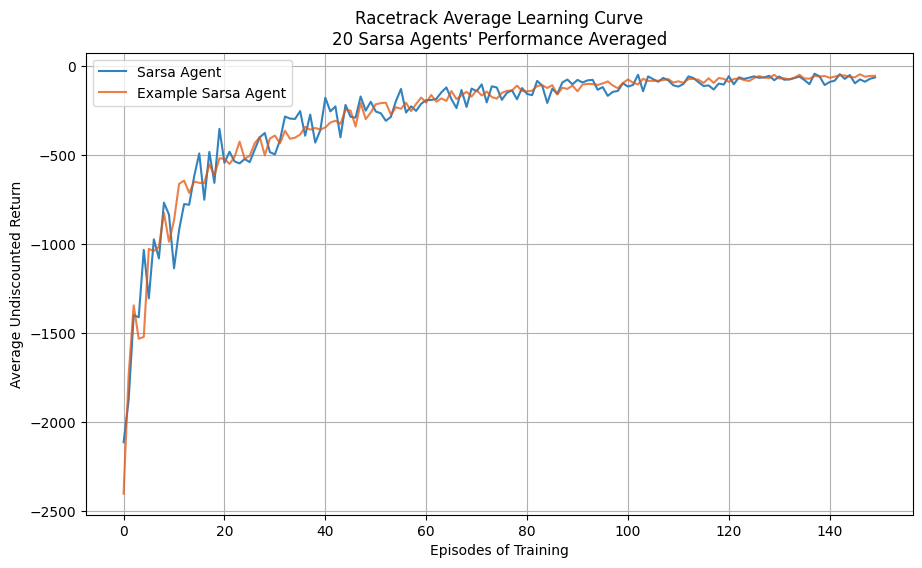

In [56]:
from racetrack_env import plot_results
from racetrack_env import simple_issue_checking

# Checking Sarsa Results for Obvious Issues.
simple_issue_checking(sarsa_rewards)

# Plotting Sarsa Learning Curve.
%matplotlib inline
plot_results(sarsa_rewards = sarsa_rewards)

## Exercise 2: Q-Learning

In this exercise, you will implement an agent which learns to reach a goal state in the racetrack task using the Q-Learning algorithm, the pseudocode for which is reproduced below (Reinforcement Learning, Sutton & Barto, 2018, Section 6.5 p.131).

<img src="images/q_learning_algo.png" style="width: 650px;"/>

Please use the following parameter settings:
- Step size parameter $\alpha = 0.2$.
- Discount factor $\gamma = 0.9$.
- For your $\epsilon$-greedy policy, use exploratory action probability $\epsilon = 0.15$.
- Number of training episodes $= 150$.
- Number of agents averaged should be at **least** 20.

**If you use incorrect parameters, you may not get any credit for your work.**

Your implementation of a tabular **Q-Learning** agent should produce a list named `q_learning_rewards`. This list should contain one list for each agent that you train. Each sub-list should contain the undiscounted sum of rewards earned during each episode by the corresponding agent. <br />
For example, if you train $20$ agents, your `q_learning_rewards` list will contain $20$ sub-lists, each containing $150$ integers. Below your implementation, we will use this list to plot a **learning curve**, which shows the average return earned by your agents each episode.

Hint: Your Q-Learning implementation is likely to be similar to your Sarsa implementation. Think hard about where these two algorithms differ.

In [57]:
def create_q_table():
    q = {
        (a, b, c, d): {k: 0 for k in range(9)}
        for a in range(1, 40)
        for b in range(1, 40)
        for c in range(-10, 11)
        for d in range(-10, 11)
    }
    return q
def init_epsilon_policy(n_actions):
    policy={
        (a, b, c, d): {k: 1/n_actions for k in range(9)}
        for a in range(1, 18)
        for b in range(1, 14)
        for c in range(-10, 11)
        for d in range(-10, 11)
    }
    return policy
def epsilon_greedy_policy(q,state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(list(q[state].keys()))
    else:
        max_value = max(q[state].values())
        best_action =[action for action,value in q[state].items() if value == max_value]
        return random.choice(best_action)
def q_learning(env,q_table,num_episodes,alpha,gamma,epsilon):
    ep_rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        while True:
            action = epsilon_greedy_policy(q_table,state, epsilon)
            next_state, reward, terminal = env.step(action)
            q_table[state][action] += alpha*(reward + gamma*q_table[next_state][max(q_table[next_state], key=q_table[next_state].get)] - q_table[state][action])
            state = next_state
            episode_reward += reward
            if terminal:
                break
        ep_rewards.append(episode_reward)
    return q_table, ep_rewards
env = RacetrackEnv()

In [58]:
# Please write your code for Exercise 2 in this cell or in as many cells as you want ABOVE this cell.
# You should implement your q-learning agent here.
# Do NOT delete this cell.

# YOUR CODE HERE
alpha = 0.2
gamma = 0.9
epsilon = 0.15
q_learning_rewards = []
for i in range(20):
    q_table = create_q_table()
    q_learning_rewards.append(q_learning(env,q_table,150,alpha,gamma,epsilon)[1])

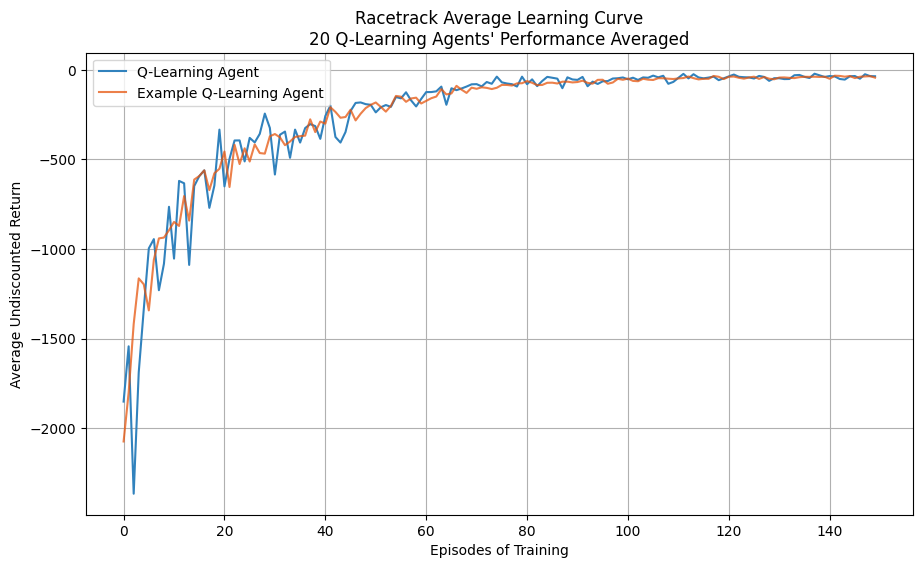

In [59]:
from racetrack_env import plot_results
from racetrack_env import simple_issue_checking

# Checking Q-Learning Results for Obvious Issues.
simple_issue_checking(q_learning_rewards)

# Plotting Q-Learning Learning Curve.
%matplotlib inline
plot_results(q_learning_rewards = q_learning_rewards)

## Exercise 3: Comparison & Discussion

Below, we have used our example results to plot learning curves for On-Policy Monte Carlo Control, Sarsa, and Q-Learning on the same set of axes. <br />
A cropped version of this learning curve has also been plotted, to make it easier to compare agents' performance towards the end of training.

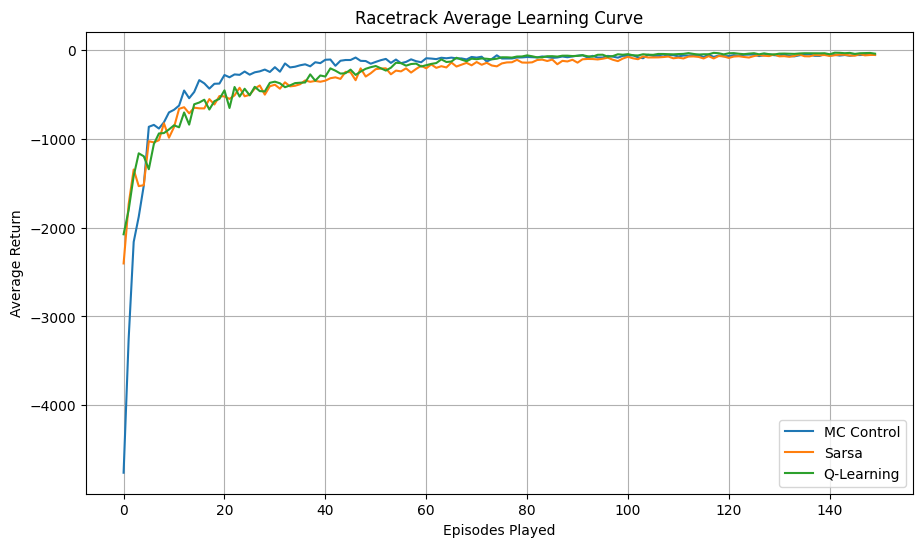

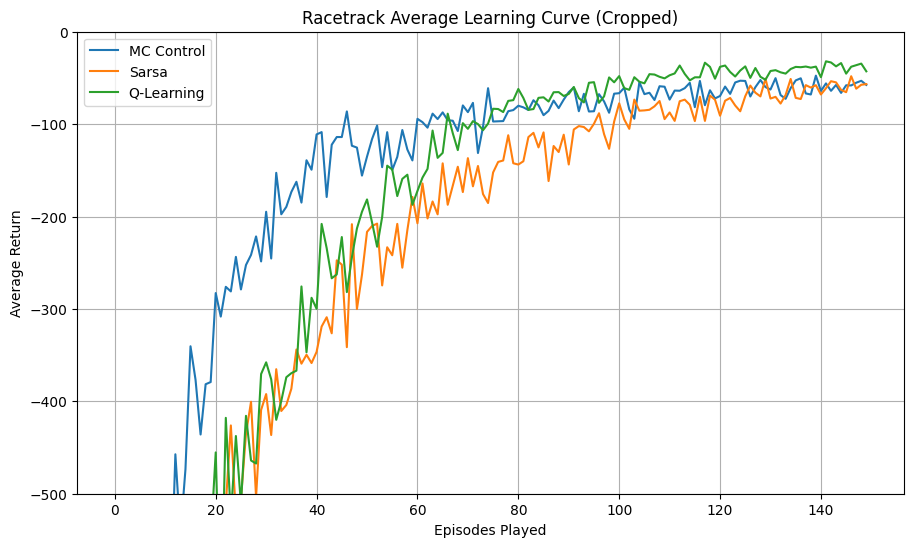

In [60]:
from racetrack_env import plot_combined_results

# Plotting Combined Learning Curve.
%matplotlib inline
plot_combined_results()

Based on these results and your understanding of these algorithms, please have a go at answering the following discussion questions in your own words. <br />

**Question 1:** Briefly compare the performance of each of your agents.

**Question 2:** Why do you think that your Monte Carlo and Temporal-Difference agents behaved differently?

**Question 3:** Does the performance of your Sarsa and Q-Learning agents meet your expectations? Why do you think that this was the case?

**Question 4:** Why do you think that the results on the Cliff-Walking problem discussed in lectures were not replicated in this environment?

**Question 5:** What algorithmic changes could be made to improve the performance of your agents?

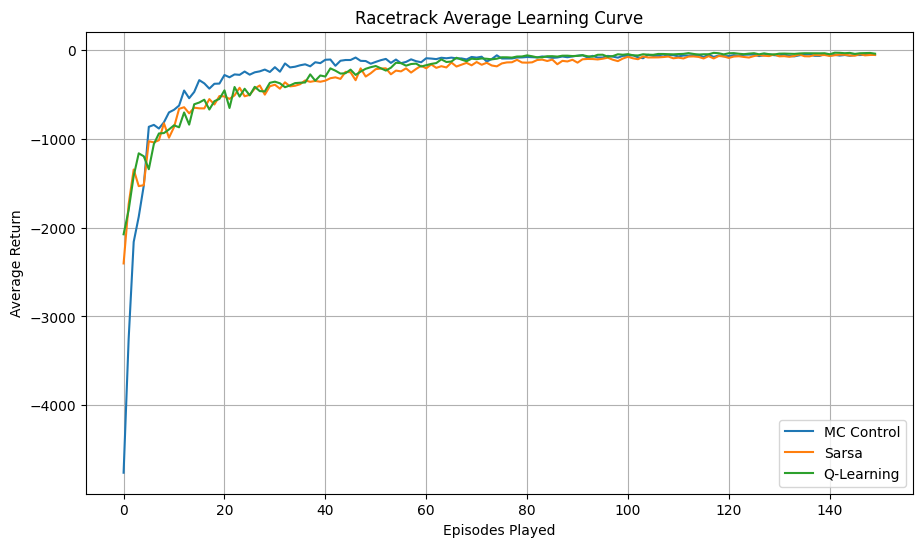

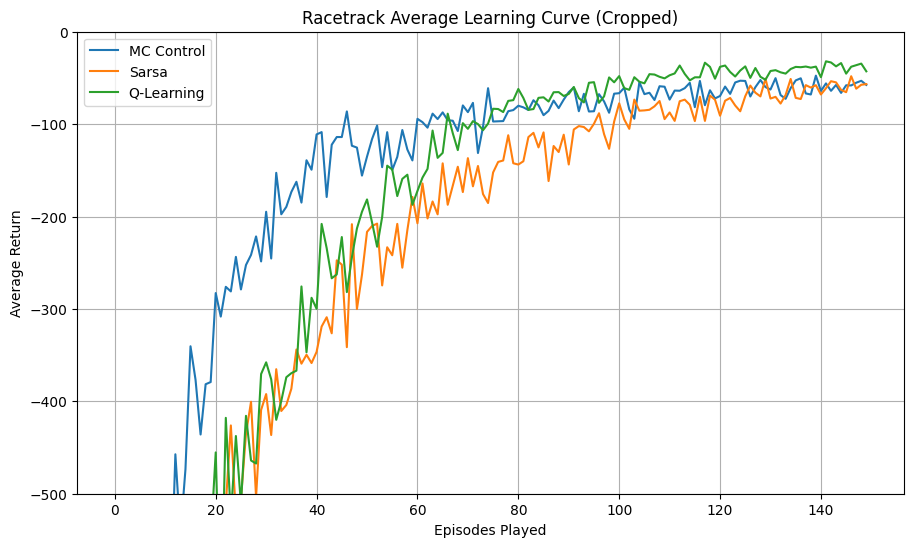

In [64]:
import time
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from IPython.display import clear_output

from matplotlib import colors
with open("correct_returns_q.json", "r") as f3:
    q_learning_rewards = json.load(f3)
with open("correct_returns_sarsa.json", "r") as f4:
    sarsa_rewards = json.load(f4)
plot_combined_results()